# 뉴스기사 요약해보기

* 추상적 요약과 추출적 요약을 모두 해보기

### 텍스트 요약(Text Summarization)이란?

 * 텍스트 요약(Text Summarization)이란, 
  - 긴 길이의 문서(Document) 원문을 핵심 주제만으로 구성된 짧은 요약(Summary) 문장들로 변환하는 것을 말합니다
  - ex) 작은 텍스트인 뉴스 제목 뽑기
  
 * 중요한 것은 요약 전후에 정보 손실 발생이 최소화되어야 한다는 점

### 추출적 요약(Extractive Summarization)
 * 단어 그대로 원문에서 문장들을 추출해서 요약하는 방식
  - 핵심적인 문장을 꺼내와서 몇개의 문장으로 구성된 요약문을 만드는 식
  - 머신 러닝 방식에 속하는 텍스트 랭크(TextRank) 알고리즘을 사용
  - ex) 네이버 뉴스 서비스에 있는 요약봇 기능
  - 문장 분류(Text Classification) 문제로 볼 수 있다

### 추상적 요약(Abstractive Summarization)
 * 원문으로부터 내용이 요약된 새로운 문장을 생성
   - 새로운 문장이라는 것은 결과로 나온 문장이 원문에 원래 없던 문장일 수도 있다는 것을 의미
   - 자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역
   - RNN : 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어렵다는 문제가 있습니다. 순차 데이터(Sequential data)
   - RNN의 문제를 해결하기 위해 LSTM과 GRU가 등장
   - 이 둘도 부족해서 어텐션(Attention) 메커니즘이 등장
   - 장기 종속성 문제(Long-Term Dependency Problem)
   - 장기 종속성 문제는 순차 데이터에서 학습 시 중요한 정보가 데이터의 시작 부분에 위치할 경우, 
     네트워크가 시간 경과에 따라 그 정보를 잊어버리는 현상을 말합니다

### 주요 라이브러리 버전을 확인

In [88]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


### Step 1. 데이터 수집하기

* 데이터 : 뉴스 기사 데이터(news_summary_more.csv)를 사용
* 참조링크 : sunnysai12345/News_Summary (https://github.com/sunnysai12345/News_Summary)

In [89]:
# 데이터를 다운로드
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [90]:
data.sample(10)

,headlines,text
22795,15-yr-old boy arrested for killing aunt with t...,A 15-year-old boy in Tamil Nadu's Chennai has ...
30098,Jamia's website hacked with 'Happy B'day Pooja...,The official website of Jamia Millia Islamia U...
62501,"Dr Reddy's, Sun Pharma sued over US price-fixi...",Five Indian generic drugmakers including Dr Re...
92708,50% of India's energy capacity from non-fossil...,Over 50% of India's installed power capacity w...
93037,Air Canada bumps 10-year-old boy from flight,"Air Canada has apologised and offered a ""very ..."
75735,DU girls sleep outside admin block to protest ...,Female students of Delhi University's Hindu Co...
59556,"1 dead, 3 injured after 3-storey building coll...",At least one person died and three people have...
47071,Maha signs Ã¢ÂÂ¹35k cr MoU with man who built...,The Maharashtra government on Monday signed a ...
62805,80 militants killed in Kashmir in 6 months: In...,Around 80 militants have been killed in south ...
43746,French baker fined Ã¢ÂÂ¹2.5 lakh for working ...,A French court has fined baker CÃÂ©dric Vaivr...


In [91]:
# 작업폴더 생성
!mkdir -p ~/aiffel/news_summary_more/data

* data1폴더를 생성하고 그 폴더에 news_summary_more.csv 파일을 업로드 한다.

In [92]:
#다운로드한 csv파일을 샐성한 작업폴더에 링크 복사함
!ln -s ~/data1/*.csv ~/aiffel/news_summary_more/data

ln: failed to create symbolic link '/aiffel/aiffel/news_summary_more/data/news_summary_more.csv': File exists


* NLTK의 불용어(stopwords)를 사용
* NLTK를 설치하고 NTLK의 데이터셋을 다운로드
* NLTK : Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리
* 불용어를 제거하는 작업을 진행
* NLTK 패키지에서 불용어 사전을 다운로드

In [93]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
#데이터셋 로드
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summary_more/data/news_summary_more.csv")

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [95]:
# text와 headlines 컬럼의 데이터만 존재

data = data[['text', 'headlines']]  # 'text'와 'headlines' 컬럼만 존재
data.head()  #데이터의 첫 5개 행 확인

,text,headlines
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


In [96]:
#랜덤한 10개 샘플 출력
data.sample(10)

,text,headlines
10890,A United Nations' study has revealed that the ...,Ozone layer will be completely healed by 2060s...
42272,"On the occasion of Earth Hour on Saturday, Mad...",MP CM Shivraj holds meeting in candlelight dur...
86211,Adani Group will proceed with its $16.5 billio...,Adani gives final approval to controversial Au...
16547,"In an attempt to highlight the Kashmir issue, ...",Pak issues stamps commemorating Burhan Wani as...
15121,The teaser of the Kangana Ranaut starrer 'Mani...,Teaser of Kangana Ranaut starrer 'Manikarnika'...
55376,Reacting to brother Krunal Pandya's wedding an...,Caught n Bowled: Hardik on brother's marriage ...
47091,An all-woman crew on Monday started operating ...,"All-woman crew operate Jaipur station, in 1st ..."
61494,"IT giant Infosys' Co-founder Senapathy ""Kris"" ...",Infosys Co-founder invests in big data startup...
41855,Elon Musk-led electric carmaker Tesla's shares...,"Tesla's shares fall 8% in a day, hits lowest v..."
68926,"Vishwas Gupta, ex-husband of Honeypreet Insan,...",Ram Rahim made us play Bigg Boss: Honeypreet's...


* text 열의 내용을 요약한 것이 headlines 열

* 기사의 본문에 해당되는 text, headlines 두 가지 열로 구성
* 추상적 요약 : text를 본문, headlines를 이미 요약된 데이터로 모델을 학습
* 추출적 요약 : text열만을 사용

In [97]:
# 첫 번째 행의 텍스트 데이터와 길이를 출력
first_text = data.loc[0, 'text']  # 첫 번째 행의 'headlines' 컬럼 데이터
text_length = len(first_text)    # 텍스트의 길이 계산

print("첫 번째 행의 text 내용:", first_text)
print("첫 번째 행의 text 길이:", text_length)

# 첫 번째 행의 텍스트 데이터와 길이를 출력
first_head_text = data.loc[0, 'headlines']  # 첫 번째 행의 'headlines' 컬럼 데이터
text_head_length = len(first_head_text)    # 텍스트의 길이 계산

print("첫 번째 행의 headlines 내용:", first_head_text)
print("첫 번째 행의 headlines 길이:", text_head_length)

첫 번째 행의 text 내용: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
첫 번째 행의 text 길이: 375
첫 번째 행의 headlines 내용: upGrad learner switches to career in ML & Al with 90% salary hike
첫 번째 행의 headlines 길이: 65


### Step 2. 데이터 전처리하기 (추상적 요약)

* 텍스트를 정규화 또는 정제
* 불용어 제거를 선택, 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민

### (1) 데이터 정리하기

In [98]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [99]:
print('text 열에서 고유값 종류 :', data['text'].unique())
print('headlines 열에서 고유값 종류 :', data['headlines'].unique())

text 열에서 고유값 종류 : ["Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
 "Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."
 "New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to Ma

### 중복 샘플을 제거

In [100]:
# 데이터프레임의 drop_duplicates()를 사용하여, 중복 샘플을 제거

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### Null 값이 있는지 확인

In [101]:
#데이터프레임에 Null 값이 있는지 확인하는 방법은 .isnull().sum()을 사용

print(data.isnull().sum())

text         0
headlines    0
dtype: int64


### 텍스트 정규화와 불용어 제거

* 텍스트 정규화(text normalization) : 같은 의미인데도 다른 표현으로 쓰인 단어를 학습 전에 미리 같은 표현으로 통일시켜주는 것
* 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성

In [102]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


* 불용어(stopwords): 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들

In [103]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

* NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179
* 불용어를 제거, 모든 영어 문자는 소문자로 변경, 섞여있는 html 태그를 제거, 정규 표현식을 통해 각종 특수문자를 제거
* text 전처리 시에서만 호출, headlines 전처리할 때는 호출하지 않을 예정
* Abstractive한 문장 요약을 위해서 remove_stopwords를 추가

### 구현한 데이터 전처리 함수

In [104]:
# 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:        
        # 문장을 공백 기준으로 나누어 단어 리스트생성(sentence.split), 단어가 불용어에 속하지 않을 경우만 포함, 길이가 1 이하인 단어 제거
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    # 불용어 미제거 (headlines)
    else:
        #불용어를 제거하지 않고, 단순히 길이가 1 이하인 단어만 제외하고 나머지를 모두 포함
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

print('=3')

=3


### 데이터 전처리 test 결과

In [105]:
# 전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 headlines을 만들어 함수를 호출

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [107]:
# 훈련 데이터 전체의 text 컬럼의 데이터를 전처리하는 코드를 작성
# 전체 text 데이터에 대한 전처리 
clean_text = []

# 데이터프레임 data의 text 컬럼에 대해 전처리 실행
for text in data['text']:
    clean_text.append(preprocess_sentence(text))    

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [128]:
# 전체 headlines 데이터에 대한 전처리
clean_headlines = []

# 데이터프레임 data의 headlines 컬럼에 대해 전처리 실행
for text in data['headlines']:
    clean_headlines.append(preprocess_sentence(text, False))   

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'rahat fateh ali khan denies getting notice for smuggling currency', 'india get all out for their lowest odi total in new zealand']


In [109]:
import numpy as np

data['text'] = pd.Series(clean_text)   # Series로 변환 후 저장
data['headlines'] = pd.Series(clean_headlines)

# 빈 값을 Null 값으로 변환
data['text'].replace('', np.nan, inplace=True)  # Text 컬럼에 대해 빈 값을 NaN으로 변환
data['headlines'].replace('', np.nan, inplace=True)  # Summary 컬럼에 대해 빈 값을 NaN으로 변환

print('=3')

=3


In [110]:
# Null 값이 생겼는지 해볼게요.

data.isnull().sum()

text         41
headlines    41
dtype: int64

In [111]:
data['text'].isnull().sum()

41

In [112]:
data['headlines'].isnull().sum()

41

In [113]:
# 전체 Null 값을 확인 및 제거
data.dropna(axis=0, inplace=True)  # Null 값이 포함된 행 제거
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98319


In [114]:
print(data.nunique())

text         98281
headlines    98127
dtype: int64


In [115]:
data.isnull().sum()

text         0
headlines    0
dtype: int64

### (2) 훈련데이터와 테스트데이터 나누기

* 학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시

### 샘플의 최대 길이 정하기

* Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.0997670846937
요약-헤드라인의 최소 길이 : 1
요약-헤드라인의 최대 길이 : 16
요약-헤드라인의 평균 길이 : 9.29977928986259


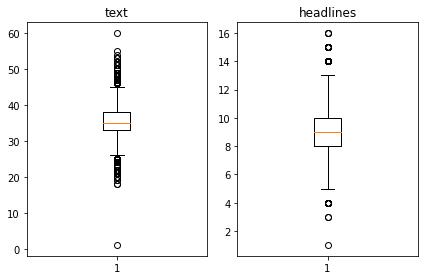

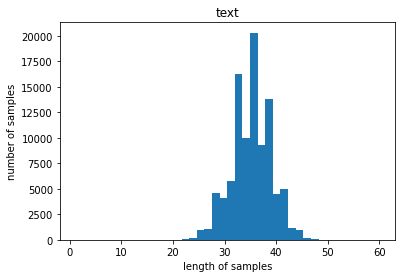

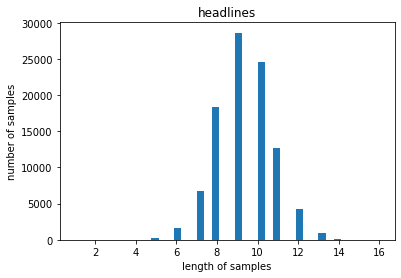

In [116]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약-헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약-헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약-헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

#실제 텍스트와 요약-헤드라인의 길이 분포
plt.subplot(1,2,1)  #Text
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)  #Summary
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

#실제 텍스트 샘플 길이별 개수
plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#요약본 샘플 길이별 개수
plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [117]:
# Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정하기

text_max_len = 40
headlines_max_len = 12
print('=3')

=3


In [118]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수 만들기

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

print('=3')

=3


In [119]:
# text와 headlines에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 확인하기

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238702590547097
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.988038934488756


In [120]:
# text와 headlines 컬럼에서 max_len 초과 샘플을 제외
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 89738


### 시작 토큰과 종료 토큰 추가하기

* 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작
* 종료 토큰을 예측한 순간에 문장 생성을 멈춤
* 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요
* 시작 토큰 : sostoken, 종료 토큰: eostoken,  앞, 뒤로 추가
  - 시작 토큰이 맨 앞에 있는 문장의 이름 : decoder_input
  - 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름 : decoder_target

In [121]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india recorded lowest odi total new zealand ge...,india get all out for their lowest odi total i...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [122]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

print('=3')

=3


* 훈련 데이터와 테스트 데이터를 분리(직접코딩, 분리 패키지를 사용)

In [123]:
# 직접코딩, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[19414 42849 87892 ...   470 55095 35677]


In [124]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의하여 섞어주기

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [125]:
#  8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)  #검증데이터
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17947


In [126]:
#:표시의 위치에 주의
encoder_input_train = encoder_input[:-n_of_val]  #훈련데이타 (처음~80%까지)
decoder_input_train = decoder_input[:-n_of_val]  #훈련 디코더 입력start (처음~80%까지)
decoder_target_train = decoder_target[:-n_of_val] #훈련 디코더 label end  (처음~80%까지)

encoder_input_test = encoder_input[-n_of_val:]   #테스트데이타 (20%~끝까지)
decoder_input_test = decoder_input[-n_of_val:]   #테스트 디코더 입력 start  (20%~끝까지)
decoder_target_test = decoder_target[-n_of_val:] #테스트 디코더 label end (20%~끝까지)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71791
훈련 레이블의 개수 : 71791
테스트 데이터의 개수 : 17947
테스트 레이블의 개수 : 17947


### (3) 정수 인코딩

### 단어 집합(vocabulary) 만들기 및 정수 인코딩

* 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요
* 고유한 정수를 맵핑하는 작업이 필요, 이 과정을 단어 집합(vocabulary) 을 만든다고 표현
* 훈련 데이터에 대해서 단어 집합을 만들기, encoder_input_train에 대해서 단어 집합을 만들게요
* Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요

In [127]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


* 현재 생성된 단어 집합 : src_tokenizer.word_index에 저장
* 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행 
* 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
* 단어와 각 단어의 등장 빈도수가 저장 : src_tokenizer.word_counts.items()

### encoder_input_train : 훈련데이타 처리

In [129]:
# 통계적인 정보 (encoder_input_train : 훈련데이타)

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('rare_freq:',rare_freq)
print('total_freq:',total_freq)
    
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

rare_freq: 90909
total_freq: 2477921
단어 집합(vocabulary)의 크기 : 65560
등장 빈도가 6번 이하인 희귀 단어의 수: 44659
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20901
단어 집합에서 희귀 단어의 비율: 68.11928004881025
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.6687610299117686


In [130]:
# 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거
# 제외한 단어 집합의 크기를 2만여 개로 계산
# 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있음

src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

print('=3')

=3


In [131]:
# texts_to_sequences() : 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
# 현재 단어 집합의 크기를 20,000으로 제한
# 이제 20,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않아요

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[126, 694, 25, 9219, 711, 65, 4004, 4338, 148, 106, 497, 806, 869, 1550, 869, 1550, 738, 369, 15725, 207, 222, 126, 93, 5032, 475, 1550, 7168, 6647, 2894, 906, 6, 1802, 25, 9219, 711], [164, 18, 62, 1454, 353, 484, 4891, 4801, 262, 6944, 57, 10281, 901, 3865, 1043, 20, 4801, 262, 6317, 1615, 1724, 2, 13, 361, 353, 484, 269, 1125, 355, 262, 1509, 262, 3008, 300], [1866, 8, 455, 1444, 1227, 1640, 992, 3157, 1837, 18343, 1478, 6165, 4339, 10021, 15726, 3157, 6, 302, 5033, 695, 1853, 1412, 708, 3924, 4121, 95, 12109, 1317, 3157, 3336, 2881]]


### Summary 데이터에 대해서도 동일한 작업을 수행

In [132]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


* 각 단어에 고유한 정수가 부여 : tar_tokenizer.word_index에 저장
* 단어와 각 단어의 등장 빈도수가 저장 : tar_tokenizer.word_counts.items() 저장
* 통계적인 정보, 등장 빈도수가 6회 미만인 단어들이 얼만큼의 비중을 차지하는지 확인

In [134]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('rare_freq:', rare_freq) 
print('total_freq:', total_freq)    
     
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

rare_freq: 36061
total_freq: 735698
단어 집합(vocabulary)의 크기 : 28766
등장 빈도가 5번 이하인 희귀 단어의 수: 18821
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9945
단어 집합에서 희귀 단어의 비율: 65.42793575749148
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.9016036471486935


* 5회 이하인 단어들은 단어 집합에서 약 65%를 차지
* 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.9%
* 이 단어들은 모두 제거
* 어림잡아 9900을 단어 집합의 크기로 제한

In [135]:
tar_vocab = 9900
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 157, 906, 1928, 3, 851, 205, 7241], [1, 62, 4709, 7, 67, 27, 2953, 1333, 815, 369, 360, 1647], [1, 2889, 23, 46, 3, 176, 1565, 93], [1, 350, 1501, 316, 459, 2699, 25, 16, 1255, 926], [1, 153, 283, 10, 7750, 4112, 32, 1869, 5815]]
target
decoder  [[157, 906, 1928, 3, 851, 205, 7241, 2], [62, 4709, 7, 67, 27, 2953, 1333, 815, 369, 360, 1647, 2], [2889, 23, 46, 3, 176, 1565, 93, 2], [350, 1501, 316, 459, 2699, 25, 16, 1255, 926, 2], [153, 283, 10, 7750, 4112, 32, 1869, 5815, 2]]


* 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 -> 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요
* 요약문(headlines)에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요
* 주의할 점은 요약문인 decoder_input: sostoken, decoder_target : eostoken 이 추가된 상태로 단어 집합 제한에도 삭제되지 않아요
* 요약문의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요, 

* 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장
* 이 샘플들은 모두 삭제

In [136]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1] #요약문의 길이가 1인 경우 갯수
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71790
훈련 레이블의 개수 : 71790
테스트 데이터의 개수 : 17947
테스트 레이블의 개수 : 17947


### 패딩하기

* 서로 다른 길이의 샘플들을 병렬 처리하기 위해, 같은 길이로 맞춰주는 패딩 작업필요
* 아까 정해두었던 최대 길이로 패딩
* 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춘다.

In [138]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')

decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

print('=3')

=3


### ------ 전처리 과정 끝

### 모델 설계하기

### 함수형 API를 이용해서 인코더를 설계

In [139]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

* dropout : 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법
* recurrent dropout :  dropout을 레이어가 아닌 time step마다 해주는 방식
  - 즉 time step의 입력을 랜덤으로 생략해 주는 것
  - 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다
* dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout

### 디코더를 설계

In [140]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3]) #인코더의 마지막 LSTM 상태를 디코더에 전달하도록 수정

* LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요

### 디코더의 출력층을 설계

In [141]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

* 디코더의 출력층은, Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀러야 한다.
* Dense의 인자로 tar_vocab, 활성화 함수로 소프트맥스 함수 사용
* 인코더의 hidden state와 cell state를 초기 state로 사용하는 가장 기본적인 seq2seq
* 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법 : 어텐션 메커니즘

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

* 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요
* 어텐션 메커니즘을 사용한 seq2seq를 설계

In [143]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
#attn_out = attn_layer([decoder_outputs, encoder_outputs])
attn_out = attn_layer([decoder_outputs, encoder_output3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

* 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

### 모델 훈련하기

* 설계한 모델을 가지고 훈련을 진행

In [144]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
281/281 [==============================] - 33s 93ms/step - loss: 5.6424 - val_loss: 5.2431
Epoch 2/50
281/281 [==============================] - 26s 91ms/step - loss: 5.0696 - val_loss: 4.8636
Epoch 3/50
281/281 [==============================] - 26s 93ms/step - loss: 4.7429 - val_loss: 4.5989
Epoch 4/50
281/281 [==============================] - 26s 92ms/step - loss: 4.4870 - val_loss: 4.4327
Epoch 5/50
281/281 [==============================] - 26s 92ms/step - loss: 4.2871 - val_loss: 4.2932
Epoch 6/50
281/281 [==============================] - 26s 92ms/step - loss: 4.1185 - val_loss: 4.1791
Epoch 7/50
281/281 [==============================] - 26s 92ms/step - loss: 3.9719 - val_loss: 4.0973
Epoch 8/50
281/281 [==============================] - 26s 92ms/step - loss: 3.8425 - val_loss: 4.0170
Epoch 9/50
281/281 [==============================] - 26s 92ms/step - loss: 3.7257 - val_loss: 3.9588
Epoch 10/50
281/281 [==============================] - 26s 92ms/step - loss: 3.623

* 조기 종료를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할
* es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 
  - val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 
    증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정
* EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있음

### 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

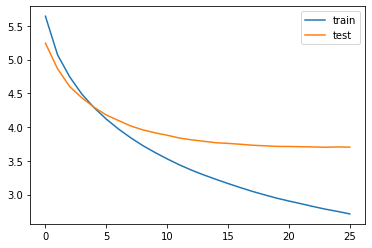

In [145]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

* 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원 필요
* 필요한 3개의 사전을 아래와 같이 미리 준비

In [146]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


* seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것
* 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로
  인코더와 디코더를 엮은 통짜 모델 하나만 준비
* 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에
  부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다.
*  이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

### 인코더 설계

In [147]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


### 어텐션 메커니즘을 사용하는 출력층을 설계

In [148]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


### 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기

In [154]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

print('=3')

=3


### 모델 테스트하기

* 테스트 단계에서는 정수 시퀀스 -> 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다
* text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고, (seq2text 함수)
* headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외 (seq2summary 함수)

In [155]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if (i!=0) and (i != tar_word_to_index['sostoken']) and (i != tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

* 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교

In [156]:
for i in range(50, 70):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former uttar pradesh cm akhilesh yadav monday alleged bjp government state failed create job opportunities state address farmer issues debt ridden farmers committing suicide future youth dark said said students raise issues sent jail 
실제 요약 : up govt failed to create jobs address farm ex cm 
예측 요약 :  akhilesh yadav calls people money to kill up


원문 : ahead republic day parade noida police issued traffic advisory banning entry heavy transport vehicles delhi noida thursday night friday afternoon entry heavy vehicles banned kunj new ashok nagar border police said vehicles allowed ply police added 
실제 요약 : entry of heavy vehicles to delhi banned before republic day 
예측 요약 :  noida metro to protest against vehicles over pollution


원문 : rss ideologue du professor rakesh sinha mistaken protestor police detained bharat bandh protests alleged dilution sc st act going take part panel discussion media house noida pulled inside police jeep said released 
실제 요약 : rss mistaken for detained du

### Step 5. Summa을 이용해서 추출적 요약해보기

* 추상적 요약 : 문장의 표현력을 다양하게, 난이도가 높아요
* 추출적 요약 : 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것, 잘못된 요약이 나올 가능성이 낮아요
* Summa의 summarize를 사용하여 추출적 요약 해보기

* seq2seq를 통해서 추상적 요약을 진행
* 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법
* 패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공
* 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법 익히기

### 패키지 설치 (summa 설치)

In [157]:
!pip install summa

In [158]:
!pip list | grep summa

summa                         1.2.0


### 데이터 다운로드하기

In [159]:
import requests
from summa.summarizer import summarize

In [160]:
# 매트릭스 시놉시스를 다운로드

text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [161]:
# text에는 매트릭스 시놉시스가 문자열로 저장
# 일부만 출력해보고, 잘 저장이 되었는지 확인

print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기

* Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아보기
* ===========================================================
* text (str) : 요약할 테스트.
* ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
* words (int or None, optional) – 출력에 포함할 단어 수.
  만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
* split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

* Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행
* 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요
* 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄이기 (원문의 0.005%만을 출력)

In [162]:
print('headlines:')
print(summarize(text, ratio=0.005))

headlines:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [163]:
# 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True

print('headlines:')
print(summarize(text, ratio=0.005, split=True))

headlines:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [165]:
# 단어의 수로 요약문의 크기를 조절할 수도 있다.
# 단어를 30개만 선택

print('headlines:')
print(summarize(text, words=30))

headlines:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


# 회고

* 뉴스기사 요약하는 기능의 전처리를 통해 처리해야 하는 기능이 많은것에 일단 놀랐고, 이과정을 순서대로 정리하고
  처리하면서 해당 기능이 어떤 처리를 하는지 정리하고 테스트 하기 바빴다.
* 샘플의 최대 길이를 정하기 위하여 자료를 확인하고 결정하는 기준이 정확히 무엇인지 아직도 잘 이해가 안된다.
  수치로 확정하기 위한 경험치가 없어서 인지.
* 두번을 작성하고도 아직도 명확히 처리과정을 이해하는게 아니라서.. 더 내용을보고 실제 사용하는 방법을 알아봐야 이해가
  될거 같다.